In [3]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy.optimize
import scipy.integrate
from pylab import plt
from scipy.optimize import curve_fit
import os
import itertools
from scipy.optimize import minimize
from datetime import datetime as time

In [4]:
class fit():

    def __init__(self,Em):
        self.Em=float(Em)
        self.tau0=0.7e-11
        self.Ps=0.4

    def tau(self,E):
        return self.tau0*np.exp(E*1e4/self.Em)

    def L20(self,t,*a):
        b2=a[10]
        b21=a[8]
        tau2=self.tau(a[4])
        tau21=self.tau(a[2])
        return b2/tau2*scipy.integrate.quad(lambda t1: (t1/tau2)**(b2-1)*np.exp(-(t1/tau2)**b2)*np.exp(-((t-t1)/tau21)**b21),0,t,epsabs=0.0000001)[0]

    def L21(self,t,*a):
        b2=a[10]
        tau2=self.tau(a[4])
        return 1-np.exp(-(t/tau2)**b2)-self.L20(t,*a)

    def L101(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        b11=a[7]
        tau11=self.tau(a[1])
        return b1/tau1*scipy.integrate.quad(lambda t1: (t1/tau1)**(b1-1)*np.exp(-(t1/tau1)**b1)*np.exp(-((t-t1)/tau11)**b11),0,t,epsabs=0.0000001)[0]

    def L102(self,t,*a):
        b1=a[6]
        b12=a[9]
        tau1=self.tau(a[0])
        tau12=self.tau(a[3])
        return b1/tau1*scipy.integrate.quad(lambda t1: (t1/tau1)**(b1-1)*np.exp(-(t1/tau1)**b1)*np.exp(-((t-t1)/tau12)**b12),0,t,epsabs=0.0000001)[0]

    def L12(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return 1-np.exp(-(t/tau1)**b1)-self.L102(t,*a)

    def core_t2_110(self,t,t1,*a):
        b11=a[7]
        b111=a[8]
        tau11=self.tau(a[1])
        tau111=self.tau(a[2])
        return lambda t2: b11/tau11*((t2-t1)/tau11)**(b11-1)*np.exp(-((t2-t1)/tau11)**b11)*np.exp(-((t-t2)/tau111)**b111)

    def core_t1_110(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return lambda t1: ((t1/tau1)**(b1-1))*np.exp(-(t1/tau1)**b1)*scipy.integrate.quad(self.core_t2_110(t,t1,*a),t1,t,epsabs=0.0000001)[0]

    def L110(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return b1/tau1*scipy.integrate.quad(self.core_t1_110(t,*a),0,t,epsabs=0.0000001)[0]

    def core_t2_111(self,t,t1,*a):
        b11=a[7]
        b111=a[8]
        tau11=self.tau(a[1])
        tau111=self.tau(a[2])
        return lambda t2: b11/tau11*((t2-t1)/tau11)**(b11-1)*np.exp(-((t2-t1)/tau11)**b11)*(1-np.exp(-((t-t2)/tau111)**b111))

    def core_t1_111(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return lambda t1: ((t1/tau1)**(b1-1))*np.exp(-(t1/tau1)**b1)*scipy.integrate.quad(self.core_t2_111(t,t1,*a),t1,t,epsabs=0.0000001)[0]

    def L111(self,t,*a):
        b1=a[6]
        tau1=self.tau(a[0])
        return b1/tau1*scipy.integrate.quad(self.core_t1_111(t,*a),0,t,epsabs=0.0000001)[0]

    def dP3(self,t,*a):
        eta11=1/((1+a[15])*(1+a[15]+a[14]*(1+a[15])))
        eta12=a[15]*eta11
        eta2=a[15]*(1+a[15])*eta11
        eta3=a[14]*(1+a[15])**2*eta11
        tau_3=self.tau(a[5])
        Smax=a[12]
        d33=a[13]
        Em=self.Em
        Ps=self.Ps
        b3=a[11]
        tau3=self.tau(a[5])
        return 2*Ps*(eta3*(1-np.exp(-(t/tau3)**b3))+eta2*(2/3*self.L20(t,*a)+self.L21(t,*a))+eta12*(1/3*self.L102(t,*a)+self.L12(t,*a))+eta11*(1/3*self.L101(t,*a)+2/3*self.L110(t,*a)+self.L111(t,*a)))

    def dS3(self,t,*a):
        Ps=self.Ps
        eta11=1/((1+a[15])*(1+a[15]+a[14]*(1+a[15])))
        eta12=a[15]*eta11
        eta2=a[15]*(1+a[15])*eta11
        eta3=a[14]*(1+a[15])**2*eta11
        Smax=a[12]
        d33=0.37
        Em=self.Em
        return -Smax*(eta2*self.L20(t,*a)+eta12*self.L102(t,*a)+eta11*(self.L101(t,*a)+self.L110(t,*a)))+d33*1e-7*Em*1e3*(self.dP3(t,*a)-Ps)+a[13]*1e-9*Em**2

    def tau_print(self,*a):
        eta11=1/((1+a[15])*(1+a[15]+a[14]*(1+a[15])))
        eta12=a[15]*eta11
        eta2=a[15]*(1+a[15])*eta11
        eta3=a[14]*(1+a[15])**2*eta11
        print (eta11,eta12,eta2,eta3,eta11+eta12+eta2+eta3)

In [8]:
#Read data and define error function
data_part=10

time_p=np.loadtxt('./t_p.txt', unpack=True)[::data_part]
polarization_data=np.loadtxt('./P.txt'.format(Em), unpack=True)[::data_part]
time_s=np.loadtxt('./t_s.txt', unpack=True)[::data_part]
strain_data=np.loadtxt('./S.txt'.format(Em), unpack=True)[::data_part]
data_len=np.shape(strain_data)[0]
time_s=np.array([time_s[i] for i in range(data_len)])

minmax_p=(max(polarization_data/10**2)-min(polarization_data/10**2))
minmax_s=(max(strain_data)-min(strain_data))

P=fit(Em)
p_vect=np.vectorize(P.dP3)
s_vect=np.vectorize(P.dS3)

def err_p(args):
    e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a0,a1=args
    p=[e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a0,a1]
    return np.mean(np.sqrt((polarization_data/1e2-p_vect(time_p,*p))**2))

def err_s(args):
    e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a0,a1=args
    p=[e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a0,a1]
    return np.mean(np.sqrt((strain_data-s_vect(time_s,*p))**2))

In [11]:
#optimal parameeters search for P(t) and S(t) curves
from hyperopt import hp, tpe,rand, fmin

s=np.array([1.98,2.08,2.16,2.16,2.25,2.27, 0.3,0.72,2.7,3.05,2.58,3.61, 0.7,1.16, 1.72,0.082])
the_range=np.array([0.01,0.01,0.0,0.0, 0.0,0.0,  0.0,0.0,0.0,0.0, 0.0,0.0,  0.0,0.0, 0.0,0.0])
s1=(1-0.5*the_range)*s
s2=(1+0.2*the_range)*s

space = [hp.uniform('e1',s1[0],s2[0]),hp.uniform('e11',s1[1],s2[1]),hp.uniform('e111',s1[2],s2[2]),hp.uniform('e12',s1[3],s2[3]),
         hp.uniform('e2',s1[4],s2[4]),hp.uniform('e3',s1[5],s2[5]),
         hp.uniform('b1',s1[6],s2[6]),hp.uniform('b11',s1[7],s2[7]),hp.uniform('b111',s1[8],s2[8]),hp.uniform('b12',s1[9],s2[9]),
                    hp.uniform('b2',s1[10],s2[10]),hp.uniform('b3',s1[11],s2[11]),
                    hp.uniform('smax',s1[12],s2[12]),hp.uniform('d33',s1[13],s2[13]),hp.uniform('a0',s1[14],s2[14]),hp.uniform('a1',s1[15],s2[15])]
best_p = fmin(err_p,space,algo=tpe.suggest,max_evals=5)

space = [hp.uniform('e1',s1[0],s2[0]),hp.uniform('e11',s1[1],s2[1]),hp.uniform('e111',s1[2],s2[2]),hp.uniform('e12',s1[3],s2[3]),
         hp.uniform('e2',s1[4],s2[4]),hp.uniform('e3',s1[5],s2[5]),
         hp.uniform('b1',s1[6],s2[6]),hp.uniform('b11',s1[7],s2[7]),hp.uniform('b111',s1[8],s2[8]),hp.uniform('b12',s1[9],s2[9]),
                    hp.uniform('b2',s1[10],s2[10]),hp.uniform('b3',s1[11],s2[11]),
                    hp.uniform('smax',s1[12],s2[12]),hp.uniform('d33',s1[13],s2[13]),hp.uniform('a0',s1[14],s2[14]),hp.uniform('a1',s1[15],s2[15])]
best_s = fmin(err_s,space,algo=tpe.suggest,max_evals=5)

100%|██████████| 5/5 [03:46<00:00, 45.26s/it, best loss: 0.010996628143060407]


In [23]:
#search for an optimal parameeter set
b=best_p
res_p=[b["e1"],b["e11"],b["e111"],b["e12"],b["e2"],b["e3"],b["b1"],b["b11"],b["b111"],b["b12"],b["b2"],b["b3"],b["smax"],b["d33"],b["a0"],b["a1"]]
b=best_s
res_s=[b["e1"],b["e11"],b["e111"],b["e12"],b["e2"],b["e3"],b["b1"],b["b11"],b["b111"],b["b12"],b["b2"],b["b3"],b["smax"],b["d33"],b["a0"],b["a1"]]

def f(args):
    e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a0,a1=args
    share_p=np.array([e1,e11,e111,e12,e2,e3,b1,b11,b111,b12,b2,b3,smax,d33,a0,a1])
    share_s=1-share_p
    res=np.array(res_p)*share_p+np.array(res_s)*share_s
    p=np.mean(np.sqrt((polarization_data/10**2-p_vect(time_p,*res))**2))/minmax_p*100
    s=np.mean(np.sqrt((strain_data-s_vect(time_s,*res))**2))/minmax_s*100
    return 0.5*(p+s)

s=np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.0, 0.0, 0.5, 0.5])
s1=s-2*np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.2, 0.00,0.00, 0.2,0.2])
s2=s+2*np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.2,0.2,0.2,0.2,0.2, 0.00,0.00, 0.2,0.2])

space = [hp.uniform('e1',s1[0],s2[0]),hp.uniform('e11',s1[1],s2[1]),hp.uniform('e111',s1[2],s2[2]),hp.uniform('e12',s1[3],s2[3]),
         hp.uniform('e2',s1[4],s2[4]),hp.uniform('e3',s1[5],s2[5]),
         hp.uniform('b1',s1[6],s2[6]),hp.uniform('b11',s1[7],s2[7]),hp.uniform('b111',s1[8],s2[8]),hp.uniform('b12',s1[9],s2[9]),
                    hp.uniform('b2',s1[10],s2[10]),hp.uniform('b3',s1[11],s2[11]),
                    hp.uniform('smax',s1[12],s2[12]),hp.uniform('d33',s1[13],s2[13]),hp.uniform('a0',s1[14],s2[14]),hp.uniform('a1',s1[15],s2[15])]
best = fmin(f,space,algo=tpe.suggest,max_evals=5)
b=best
sh=[b["e1"],b["e11"],b["e111"],b["e12"],b["e2"],b["e3"],b["b1"],b["b11"],b["b111"],b["b12"],b["b2"],b["b3"],b["smax"],b["d33"],b["a0"],b["a1"]]
res=np.array(res_p)*np.array(sh)+np.array(res_s)*(1-np.array(sh))

print ('activation energies: E1={:.2f}, E11={:.2f}, E111={:.2f}, E12={:.2f}, E2={:.2f}, E3={:.2f}'.format(res[0],res[1],res[2],res[3],res[4],res[5]))
print ('Avrami indices: A1={:.2f}, A11={:.2f}, A111={:.2f}, A12={:.2f}, A2={:.2f}, A3={:.2f}'.format(res[6],res[7],res[8],res[9],res[10],res[11]))
print ('Maximum strain and piezoelectric coefficient values: S_max={:.2f}, d33={:.2f}'.format(res[12],res[13]))
print('180 and non-180 switchings: a_1={:.2f}, a_2={:.2f}'.format(res[14],res[15]))

100%|██████████| 5/5 [07:28<00:00, 89.40s/it, best loss: 3.011373683639174]
activation energies: E1=1.97, E11=2.08, E111=2.16, E12=2.16, E2=2.25, E3=2.27
Avrami indices: A1=0.30, A11=0.72, A111=2.70, A12=3.05, A2=2.58, A3=3.61
Maximum strain and piezoelectric coefficient values: S_max=0.70, d33=1.16
180 and non-180 switchings: a_1=1.72, a_2=0.08


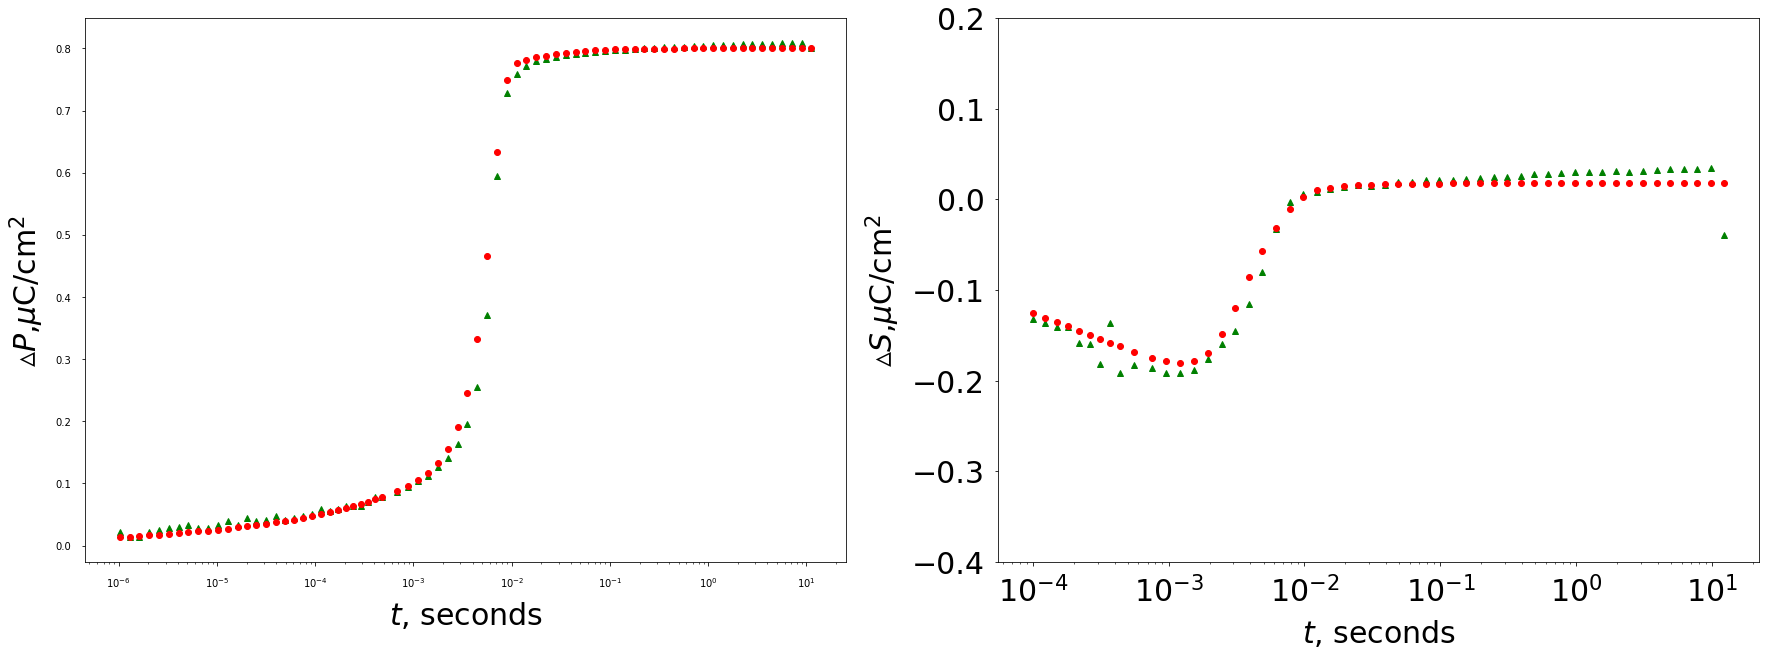

In [25]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(30, 10))
a1.plot(time_p,polarization_data/10**2,'g^')
a1.plot(time_p,p_vect(time_p,*res),"ro")
a1.set_xscale('log')
a1.set_xlabel(r'$t$, seconds',fontsize=30)
a1.tick_params(axis='x', pad=10)
a1.set_ylabel(r'$ \vartriangle$$P$,$\mu$C/cm$^2$',fontsize=30)
a1.tick_params(axis='y', pad=10)
a1.xaxis.labelpad = 10
a1.yaxis.labelpad = 10
plt.ylim(-0.1,1.1)
plt.tick_params(labelsize=30)

a2.plot(time_s,strain_data,'g^')
a2.plot(time_s,s_vect(time_s,*res),"ro")
a2.set_xscale('log')
a2.set_xlabel(r'$t$, seconds',fontsize=30)
a2.tick_params(axis='x', pad=10)
a2.set_ylabel(r'$ \vartriangle$$S$,$\mu$C/cm$^2$',fontsize=30)
a2.tick_params(axis='y', pad=10)
a2.xaxis.labelpad = 10
a2.yaxis.labelpad = 10
plt.ylim(-0.4,0.2)
plt.tick_params(labelsize=30)
plt.show()